# Best XGB Model from Feb 9th

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime 
import datetime as dt
import matplotlib.pyplot as plt

# Load and Prep Data

In [10]:
# Prep data for ML

#Load balanced data
#Even re-sample of delay and no delay from orig dataset
flights = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Data\cleaned\cleaned_balanced_sample.csv', delimiter=',', low_memory=False)
flights.head()

#Add Date Featues to table
flights['year'] = pd.to_datetime(flights['fl_date']).dt.year
flights['quarter'] = pd.to_datetime(flights['fl_date']).dt.quarter
flights['month'] = pd.to_datetime(flights['fl_date']).dt.month
flights['day_of_month'] = pd.to_datetime(flights['fl_date']).dt.day
flights['day_of_week'] = pd.to_datetime(flights['fl_date']).dt.dayofweek

#Add time features to table
flights['crs_dep_hour'] = pd.to_datetime(flights['crs_dep_time'], format='%H%M', errors ='coerce').dt.hour
flights['crs_arr_hour'] = pd.to_datetime(flights['crs_dep_time'], format='%H%M', errors ='coerce').dt.hour

#Add column with delay or no delay
flights['arr_delay_flag'] = flights['arr_delay'].map(lambda x: 1 if x > 0 else 0)

#Import weather data
weather = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Weather2\weather_table.csv', delimiter=',', low_memory=False)

#Add weather data to flights
flights = pd.merge(flights, weather, how='left', left_on=['fl_date', 'dest'], right_on = ['date_time', 'location'])

# Drop nas
flights = flights[flights['weather_type'].notna()]

#Remove duplicate columns
flights = flights.loc[:,~flights.columns.duplicated()]

# Best XGB Model

In [26]:
# XGB Model
# Classifier
# Updated features included - Added weather_type

# assign X and y
cols = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 
        'crs_arr_time', 'crs_elapsed_time', 'distance', 'weather_type']
X = flights[cols]
y = flights['arr_delay_flag']

# encode categorical columns
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cat_vars = X.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col])

# make train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xsc = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xsc, y, train_size=0.7, test_size=0.3, random_state=101)

#Model
import xgboost as xgb
model = xgb.XGBClassifier(objective = 'reg:logistic', eval_metric='auc', n_estimators=1000, learning_rate=0.001, max_depth=12)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

#Evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_score))

<ipython-input-26-bece2246c1e5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
C:\Users\Ryan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.56      0.55      0.55     90082
           1       0.55      0.56      0.56     89912

    accuracy                           0.56    179994
   macro avg       0.56      0.56      0.56    179994
weighted avg       0.56      0.56      0.56    179994

Accuracy: 0.5552740646910452
F1 Score: 0.5582827502483169
Recall: 0.562616780852389
Precision: 0.5540149822578525
AUC Score: 0.5731540258707927


Text(0.5, 637.6, 'Predicted label')

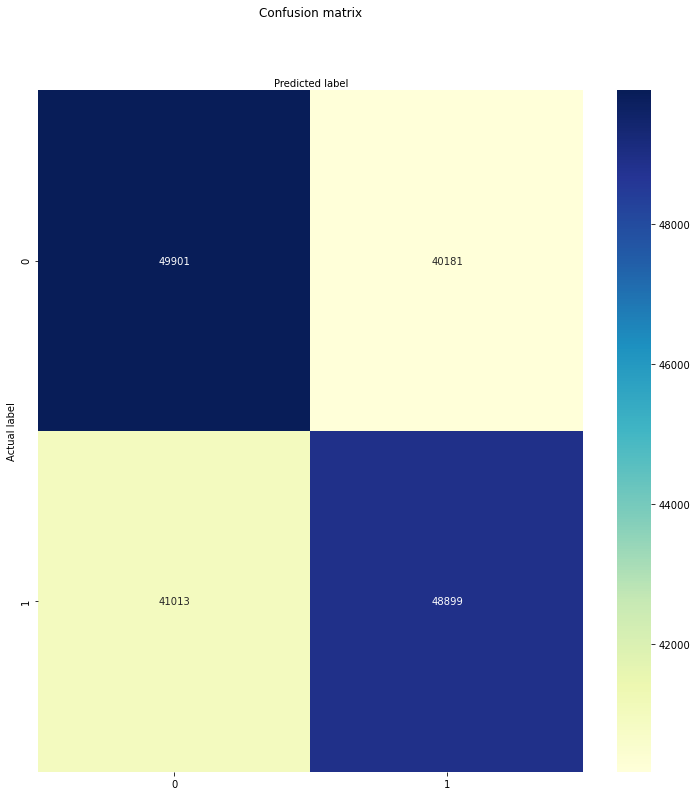

In [35]:
# Confusion Matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# create heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Feature Importance

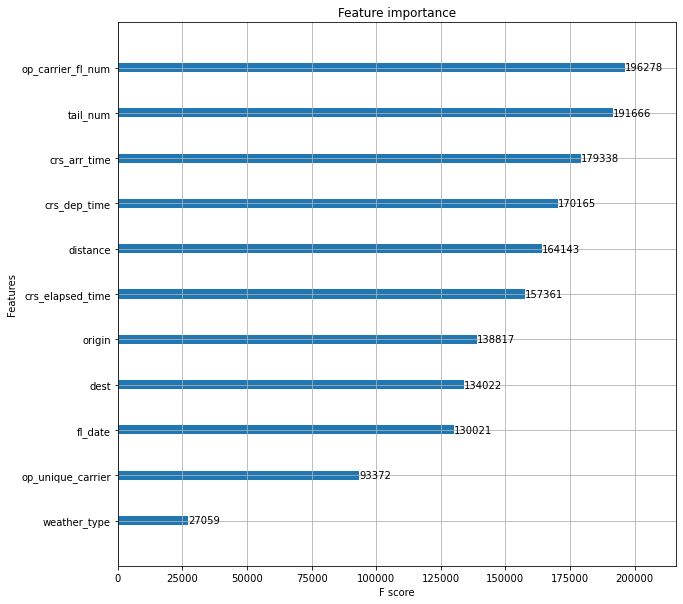

In [55]:
# Feature Importance Plot Best Model
model.get_booster().feature_names = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 
                                     'origin', 'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'weather_type']
fig = xgb.plot_importance(model.get_booster())
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

# Predict delay or no delay using flights_test and Classifier

### Load Data

In [182]:
# Prep data for ML

#Load flights_test
flights_test = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Data\cleaned\flights_test.csv', delimiter=',', low_memory=False)

#Add Date Featues to table
flights_test['year'] = pd.to_datetime(flights_test['fl_date']).dt.year
flights_test['quarter'] = pd.to_datetime(flights_test['fl_date']).dt.quarter
flights_test['month'] = pd.to_datetime(flights_test['fl_date']).dt.month
flights_test['day_of_month'] = pd.to_datetime(flights_test['fl_date']).dt.day
flights_test['day_of_week'] = pd.to_datetime(flights_test['fl_date']).dt.dayofweek

#Add time features to table
flights_test['crs_dep_hour'] = pd.to_datetime(flights_test['crs_dep_time'], format='%H%M', errors ='coerce').dt.hour
flights_test['crs_arr_hour'] = pd.to_datetime(flights_test['crs_dep_time'], format='%H%M', errors ='coerce').dt.hour

#Import weather data
weather_test = pd.read_csv(r'C:\Users\Ryan\Lighthouse\Bootcamp\w6\midterm\Weather2\weather_table_test_data.csv', delimiter=',', low_memory=False)

#Add weather data to flights
flights_test = pd.merge(flights_test, weather_test, how='left', left_on=['fl_date', 'dest'], right_on = ['date_time', 'location'])

# Drop nas
flights_test = flights_test[flights_test['weather_type'].notna()]

#Remove duplicate columns
flights_test = flights_test.loc[:,~flights_test.columns.duplicated()]

### Predict delay and no delay based on flights table

In [183]:
# Select needed features for model from flights_test and assign to X
cols = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 
        'crs_arr_time', 'crs_elapsed_time', 'distance', 'weather_type']
X = flights_test[cols]
    
# encode categorical columns
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cat_vars = X.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    X[col] = label_encoder.fit_transform(X[col].astype(str))
    

# Set feature names in model as they didn't come across from orig. Might have to do this always with xgb models
model.get_booster().feature_names = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 
                                     'origin', 'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'weather_type']

# Predict delay/nodelay with best model
y_pred = model.predict(X)

# Add prediction to flights_test
flights_test['predicted_delay_yes_no'] = y_pred

# Export to csv
flights_test[['fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest', 'predicted_delay_yes_no']].to_csv('z_flights_test_pred_classifier.csv')

<ipython-input-183-3408b233ad2f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col].astype(str))


# Summary Comments
- We wound up coming back to this classifier model, which was one of our earlier classifier models
- This is a very marginal classifier, but was the best balanced classifier that we had (i.e. does not have a tendancy to overpredict delay or no delay)

- We engineered many new features and put them into different classifier models, however these classifiers became unbalanced (i.e. overpredicted or underpredicted delay/ no delay)
- Please see our other notebooks for the documentation about our features engineering efforts and using those features in our models